In [1]:
import numpy as np
import os
import soundfile as sf
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
sys.path.append("../src")
sys.path.append("/home/han/kymatio-jtfs/")
sys.path.append("../scripts")
import ftm_ver2 as ftm
import pandas as pd
import librosa
import IPython.display as ipd
from kymatio.torch import TimeFrequencyScattering1D,Scattering1D
import torch
from kymatio.scattering1d.core import timefrequency_scattering1d as tf_scat
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import pescador
from tqdm import tqdm
import tensorflow.keras.backend as K
import copy
import math
import funcnorm

ModuleNotFoundError: No module named 'funcnorm'

## test if computed weights from NN graph makes sense

In [8]:
train_weights = np.load("/home/han/data/drum_data/train_nbr_dist_nnbr10_n5jtfsavgf_nnadvanced.npy")
train_weights.shape

(82224, 6)

In [9]:
np.max(train_weights,axis=0),np.min(train_weights,axis=0),np.mean(train_weights,axis=0)

(array([1.39088361e+18, 2.48996643e+14, 2.01643501e+11, 1.17263850e+13,
        8.80228116e+10, 8.89837497e+12]),
 array([4.09020805e+03, 8.48908070e+02, 1.62813269e+00, 6.51091807e-01,
        2.46690872e-01, 1.84856844e+00]),
 array([3.38546192e+13, 3.34768334e+09, 9.16511552e+06, 1.45816123e+08,
        2.96973694e+06, 1.77069077e+08]))

(-10000000000.0, 10000000000.0)

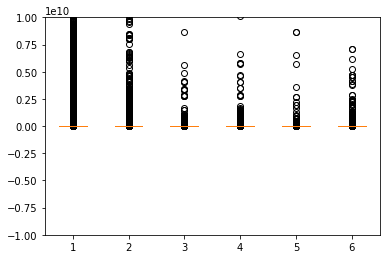

In [10]:
plt.boxplot(list(train_weights.T))
plt.ylim([-1e10,1e10])

In [13]:
#gradients 
grad = np.load("/home/han/data/drum_data/val_grad_jtfs.npy")
grads_diag = []
for i in range(grad.shape[0]):
    grads_diag.append(np.sqrt(np.diagonal(grad[i,:,:])))
grads_diag = np.stack(grads_diag,axis=0)
grads_diag.shape

(7776, 5)

In [14]:
grads_diag

array([[1.12750101e+02, 4.92868292e+01, 1.02797131e+00, 1.10547576e-02,
        3.91819012e-01],
       [1.02957357e+02, 5.11806948e+01, 7.39941906e-01, 2.49670489e-02,
        1.93747095e-01],
       [9.44548014e+01, 4.92713741e+01, 4.53452390e-01, 2.28250814e-03,
        6.45247138e-02],
       ...,
       [2.08973364e+02, 3.40379207e+01, 1.25078208e+01, 6.86606583e+01,
        5.82244870e+00],
       [3.05180159e+03, 3.31173096e+01, 1.32441824e+01, 3.95026338e+02,
        2.62608817e+01],
       [6.14029978e+03, 3.45831364e+01, 1.44692396e+01, 2.11910803e+03,
        6.42310299e+01]])

[1.69014325e+04 5.56012283e+01 2.28223732e+01 2.97964688e+04
 1.04198482e+04]


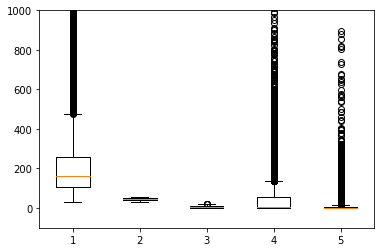

In [16]:
plt.boxplot(grads_diag)
plt.ylim([-100,1000])
print(np.max(grads_diag,axis=0))

## infer weights from gradient of JTFS
1. pick 100 normalized theta, inverse normalize it to theta
2. make a sound from parameter theta
3. calculate its jtfs coefficient
4. compute Jacobian J
5. compute theoretical bound for these sounds

In [13]:
def preprocess_gt(y_train, y_test, y_val):
    
    param_idx = [0,2,3]
    y_train_cp = copy.deepcopy(y_train)
    y_test_cp = copy.deepcopy(y_test)
    y_val_cp = copy.deepcopy(y_val)
    
    #logscale
    for idx in param_idx:
        y_train_cp[:,idx] = [math.log10(i) for i in y_train_cp[:,idx]]
        y_test_cp[:,idx] = [math.log10(i) for i in y_test_cp[:,idx]]
        y_val_cp[:,idx] = [math.log10(i) for i in y_val_cp[:,idx]]
        
    #normalize
    scaler = MinMaxScaler()
    scaler.fit(y_train_cp)
    y_train_normalized = scaler.transform(y_train_cp)
    y_val_normalized = scaler.transform(y_val_cp)
    y_test_normalized = scaler.transform(y_test_cp)

    return y_train_normalized, y_test_normalized, y_val_normalized, scaler

def inverse_scale(y_norm,scaler):
    sc_max = torch.tensor(scaler.data_max_)
    sc_min = torch.tensor(scaler.data_min_)
    
    param_idx = [0,2,3]
    y_norm_o = y_norm * (sc_max - sc_min) + sc_min
    helper = torch.ones(y_norm_o.shape)
    #inverse logscale
    for idx in param_idx:
        helper[idx] = torch.pow(10,y_norm_o[idx]) / y_norm_o[idx]
    y_norm_o = y_norm_o * helper
    return y_norm_o

#load original parameters and normalize
csv_path = "./"
df_train = pd.read_csv(os.path.join(csv_path, "train_param_v2.csv"))
df_test = pd.read_csv(os.path.join(csv_path, "test_param_v2.csv"))
df_val = pd.read_csv(os.path.join(csv_path, "val_param_v2.csv"))
y_train = df_train.values[:,1:-1]
y_test = df_test.values[:,1:-1]
y_val = df_val.values[:,1:-1]
y_train_norm, y_test_norm, y_val_norm, scaler = preprocess_gt(y_train, y_test, y_val)


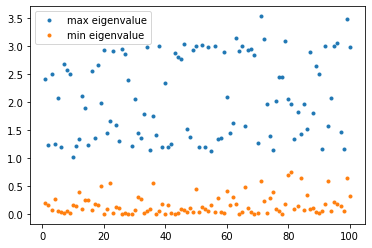

In [7]:
#load from random 100 sounds' computed JTJ
JTJs = np.load("./jacobfunctorch_100theta.npy")
max_radius = []
min_radius = []
for i in range(JTJs.shape[0]):
    DTD = np.diag(np.diagonal(JTJs[i,:,:]))
    M = JTJs[i,:,:].squeeze() - DTD.squeeze()
    Dn1 = np.diag(1/np.sqrt(np.diagonal(DTD)))
    bound = np.matmul(np.matmul(Dn1,M), Dn1)
    #obtain spectral radius
    w,_ = np.linalg.eig(bound)    
    max_radius.append(np.max(np.abs(w)))
    min_radius.append(np.min(np.abs(w)))
plt.plot(np.arange(1,101),max_radius,'.',label="max eigenvalue")
plt.plot(np.arange(1,101),min_radius,'.',label="min eigenvalue")
plt.legend()
    

In [9]:
JTJs.shape

(100, 5, 5)

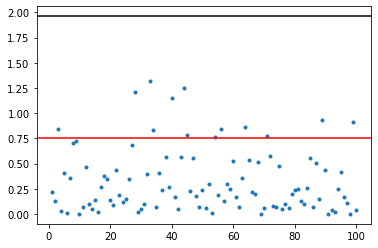

In [33]:
# find 100 random predictions
bounds = []
idx = 80
param_n = y_train_norm[idx,:]
for i in range(JTJs.shape[0]):
    param_t = y_train_norm[i+idx+1,:]
    d_param = (param_n - param_t)[:,None]
    DTD = np.diag(np.diagonal(JTJs[i,:,:]))
    M = JTJs[i,:,:].squeeze() - DTD.squeeze()
    bound = np.abs(np.matmul(np.matmul(d_param.T,M), d_param) / np.matmul(np.matmul(d_param.T,DTD), d_param))
    bounds.append(bound.squeeze())
plt.plot(np.arange(1,101),bounds,'.')
plt.axhline(y = max_radius[idx], color = 'k', linestyle = '-')
plt.axhline(y = min_radius[idx], color = 'r', linestyle = '-')
    

## least square method
1. compute (J^TJ)^-1*J^Tb

## test riemannian geometry (volumetric representation of each point)
1. take a theta_i's gradient J
2. compute its volume by sqrt(det(JTJ))
3. find neighborhood of 5 of this theta_i
4. compute the volume occupied by this neighborhood. (J*theta_diff)
5. compare the volume of neighborhood with riemannian volume

the bigger the riemann volume, the more important this point is to perception 

In [10]:
val_grad = np.load("/home/han/data/drum_data/val_grad_jtfs.npy") #JTJ of each i
#compute riemannian volume
i = 100
w,v = np.linalg.eig(val_grad[i])
print(v.shape,w.shape)
rie_vol = np.sqrt(np.prod(w))
print(rie_vol)

(5, 5) (5,)
0.019963014281420343


In [11]:
rie_vols = []
for i in range(val_grad.shape[0]):
    w,v = np.linalg.eig(val_grad[i])
    rie_vol = np.sqrt(np.prod(w))
    rie_vols.append(rie_vol)

/tmp/ipykernel_195264/2762872246.py:4: RuntimeWarning: invalid value encountered in sqrt
  rie_vol = np.sqrt(np.prod(w))


Text(0.5, 1.0, 'riemann volume vs omega')

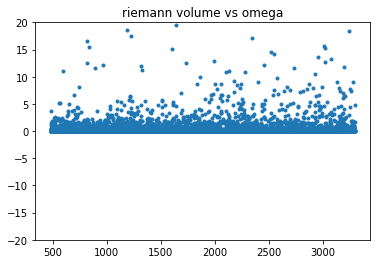

In [19]:
plt.plot(y_val[:,0],rie_vols,'.')
plt.ylim([-20,20])
plt.title("riemann volume vs omega")

Text(0.5, 1.0, 'riemann volume vs tau')

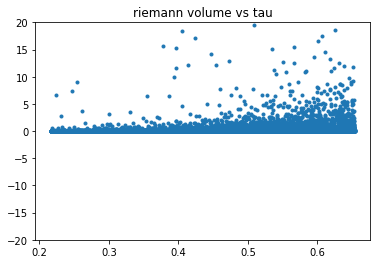

In [22]:
plt.plot(y_val[:,1],rie_vols,'.')
plt.ylim([-20,20])
plt.title("riemann volume vs tau")

Text(0.5, 1.0, 'riemann volume vs p')

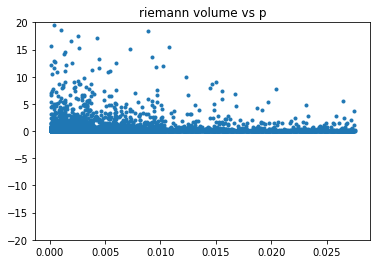

In [23]:
plt.plot(y_val[:,2],rie_vols,'.')
plt.ylim([-20,20])
plt.title("riemann volume vs p")

Text(0.5, 1.0, 'riemann volume vs D')

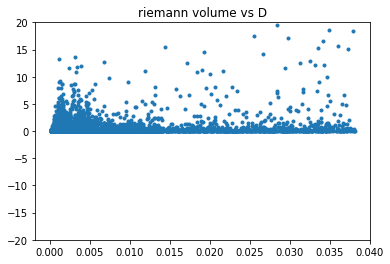

In [24]:
plt.plot(y_val[:,3],rie_vols,'.')
plt.ylim([-20,20])
plt.title("riemann volume vs D")

Text(0.5, 1.0, 'riemann volume vs alpha')

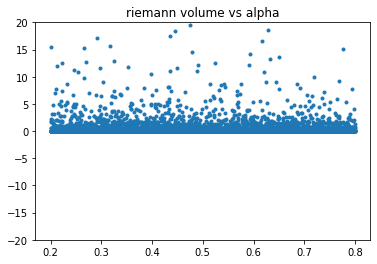

In [25]:
plt.plot(y_val[:,4],rie_vols,'.')
plt.ylim([-20,20])
plt.title("riemann volume vs alpha")

In [30]:
#assume neighbors to be the following
nbrs = [10,20,40,500,30]
#compute volume of this neighborhood = product of theta difference
np.mean(np.prod(np.abs(y_val_norm[nbrs,:]-y_val_norm[i,:]),axis=0))


0.02206920575382556

In [2]:
#FTM in torch
n_samples = 2**16
sample_rate = 22050

def getsounds_imp_linear_nonorm(m1,m2,x1,x2,h,theta,l0):
    """
    This implements Rabenstein's drum model. The inverse SLT operation is done at the end of each second-
    -order filter, no normalization on length and side length ratio is done
    """
    #print(w11,tau11,p,D,l0,alpha_side)
    w11 = theta[:,0]
    tau11 = theta[:,1]
    p = theta[:,2]
    D = theta[:,3]
    l0 = torch.tensor(l0)
    alpha_side = theta[:,4]

    l2 = l0 * alpha_side 
    s11 = -1 / tau11
    pi = torch.tensor(np.pi)

    beta_side = alpha_side + 1 / alpha_side
    S = l0 / pi * ((D * w11 * alpha_side)**2 + (p * alpha_side / tau11)**2)**0.25
    c_sq = (alpha_side * (1 / beta_side - p**2 * beta_side) / tau11**2 + alpha_side * w11**2 * (1 / beta_side - D**2 * beta_side)) * (l0 / np.pi)**2
    T = c_sq 
    d1 = 2 * (1 - p * beta_side) / tau11
    d3 = -2 * p * alpha_side / tau11 * (l0 / pi)**2 

    EI = S**4 

    mu = torch.arange(1,m1+1) #(0,1,2,..,m-1)
    mu2 = torch.arange(1,m2+1)
    #print(mu.shape,mu2.shape,l2.shape,mu,mu2)
    dur = n_samples
    Ts = 1/sample_rate
    n = (mu[None,:] * pi / l0)**2 + (mu2[None,:] * pi / l2[:,None])**2 #eta 
    n2 = n**2 
    K = torch.sin(mu * pi * x1) * torch.sin(mu2 * pi * x2) #mu pi x / l (mode)

    beta = EI[:,None] * n2[None,:] + T[:,None] * n[None,:] #(1,bs,m)
    alpha = (d1[:,None] - d3[:,None] * n[None,:])/2 # nonlinear
    omega = torch.sqrt(torch.abs(beta - alpha**2))
    #insert adaptively change mode number
    temp = (omega/2/pi) <= sample_rate / 2
    mode_corr = torch.sum(temp.to(torch.int32))

    N = l0 * l2 / 4
    yi = h * torch.sin(mu[None,None,:mode_corr] * pi * x1) * torch.sin(mu2[None,None,:mode_corr] * pi * x2) / omega[:,:,:mode_corr] #(1,bs,mode)

    time_steps = torch.linspace(0,dur,dur) / sample_rate #(T,)
    y = torch.exp(-alpha[:,:,:mode_corr,None] * time_steps[None,None,None,:]) * torch.sin(omega[:,:,:mode_corr,None] * time_steps[None,None,None,:]) # (1,bs,mode,T)

    y = yi[...,None] * y

    y = torch.sum(y * K[None,None,:mode_corr,None] / N[None,:,None,None],axis=-2) #impulse response itself
    y = y / torch.max(y,dim=-1).values[...,None]

    return y

In [2]:
grads = np.load("./grad_theta_jtfs.npy")
grads.shape

(639, 5)

In [3]:
np.random.rand(5,)

array([0.9410055 , 0.38599982, 0.55996125, 0.31714518, 0.47408978])

In [4]:
import copy

In [12]:
#take one pair of sound, prediction and ground truth
gt = np.array([0.5,0.5,0.1,0.8,0.7])
#pred = np.array([0.4,0.4,0.12,0.88,0.9])
perc = []
for i in range(1,101):
    pred = np.random.rand(5,)*10
    #pred = copy.deepcopy(gt)
    #pred[4] = i/100
    #print(pred,gt)
    #print(pred)
    #compute gradient upon ground truth theta, for every path and every parameter
    grads = np.load("./grad_theta_jtfs.npy")
    #compute diagonal terms
    diag = np.sum(grads**2 * ((gt - pred)**2)[None,:])
    #compute cross diagonal terms
    all_terms = np.sum((np.sum(grads * (gt - pred)[None,:], axis=1))**2)
    cross = all_terms - diag
    perc.append(np.abs(cross/diag)) #the smaller the better
    #print(diag, all_terms, cross)
    #print(diag/all_terms,cross/all_terms)

In [40]:
gt = np.array([0.1,0.8,0.1,0.9,0.7])
perc2 = []
for i in range(1,101):
    pred = np.random.rand(5,)*10
    #pred = copy.deepcopy(gt)
    #pred[4] = i/100
    #print(pred,gt)
    #print(pred)
    #compute gradient upon ground truth theta, for every path and every parameter
    grads = np.load("./grad_theta2_jtfs.npy")
    #compute diagonal terms
    diag = np.sum(grads**2 * ((gt - pred)**2)[None,:])
    #compute cross diagonal terms
    all_terms = np.sum((np.sum(grads * (gt - pred)[None,:], axis=1))**2)
    cross = all_terms - diag
    perc2.append(np.abs(cross/diag)) #the smaller the better
    #print(diag, all_terms, cross)
    #print(diag/all_terms,cross/all_terms)

1.5661937972326598

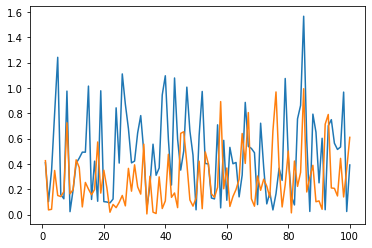

In [7]:
plt.plot(np.arange(1,101),perc)
plt.plot(np.arange(1,101),perc2)
max(perc)

In [19]:
np.max(J),np.min(J)

(2776.4446453999294, -434.40249638487893)

In [30]:
#test if square matrix's eigenvalue and singular value coincides
a = np.random.rand(5,5)
A = np.matmul(a.T,a)
A = A - np.diag(np.diagonal(A))
#print(A)
_,s,_ = np.linalg.svd(A)
w,v = np.linalg.eig(A)
print(s)
print(w) 
#symmetric positive-definite matrix has the same e-value and singular values
#symmetric matix does not coincide, 


[5.40933412 2.22742897 1.47894489 1.00481515 0.6981451 ]
[ 5.40933412 -2.22742897 -1.47894489 -0.6981451  -1.00481515]


In [41]:
#J is the grad
J = grads
JTJ = np.matmul(J.T,J)
DTD = np.diag(np.diagonal(JTJ))
M = JTJ - DTD
D = np.diag(np.sqrt(np.diagonal(JTJ)))
Dn1 = np.diag(1/(np.diagonal(D)))
#print(JTJ,DTD,D) 
#DN2 = np.diag(np.diagonal(DTD)**(-1)) #D^-2 = 1/D^2
#print(DN2,M)
MI = np.matmul(Dn1,M)
MI = np.matmul(MI,Dn1) #negative eigenvalues, meaning no C^TC to decompose MI
print(MI)

[[ 0.         -0.98676565  0.53044031  0.99994972 -0.9999493 ]
 [-0.98676565  0.         -0.60257802 -0.98786435  0.98788261]
 [ 0.53044031 -0.60257802  0.          0.53214985 -0.53232031]
 [ 0.99994972 -0.98786435  0.53214985  0.         -0.99999998]
 [-0.9999493   0.98788261 -0.53232031 -0.99999998  0.        ]]


In [42]:
_,sing_vals,_ = np.linalg.svd(MI)
w,v = np.linalg.eig(MI) #negative values??
print(max(sing_vals),sing_vals) 
print(max(w),w)

3.3424141830093412 [3.34241418 1.         0.99996847 0.98734495 0.35510076]
3.3424141830093435 [ 3.34241418 -0.35510076 -0.98734495 -0.99996847 -1.        ]


Text(0.5, 1.0, 'gradient of all path wrt each parameter in Theta')

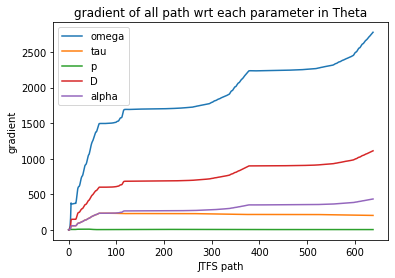

In [13]:
plt.plot(np.abs(grads),label=["omega","tau","p","D","alpha"])
#plt.plot(gradnorm[None,:],'.',label=["omega","tau","p","D","alpha"],markersize=10)
plt.legend()
plt.xlabel('JTFS path')
plt.ylabel('gradient')
plt.title("gradient of all path wrt each parameter in Theta")

Text(0.5, 1.0, 'gradient of all path wrt each parameter in Theta')

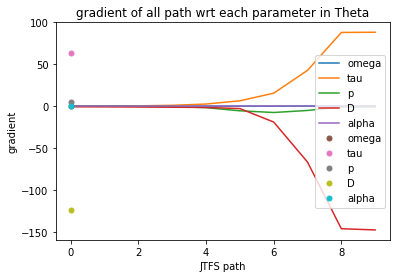

In [40]:
plt.plot(grads[:10,:],label=["omega","tau","p","D","alpha"])
plt.plot(gradnorm[None,:],'.',label=["omega","tau","p","D","alpha"],markersize=10)
plt.legend()
plt.xlabel('JTFS path')
plt.ylabel('gradient')
plt.title("gradient of all path wrt each parameter in Theta")

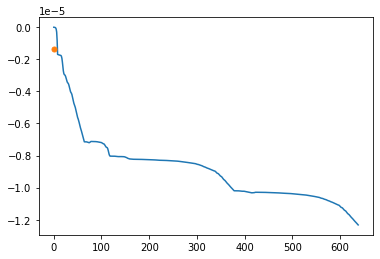

In [33]:
i = 4
plt.plot(grads[:,i])
plt.plot(gradnorm[i],'.',markersize=10)

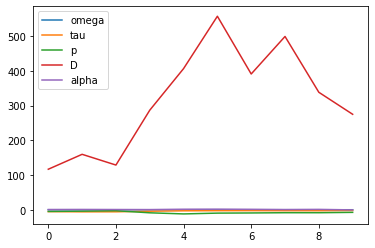

In [57]:
plt.plot(dgradsnorm,label=["omega","tau","p","D","alpha"])
plt.legend()

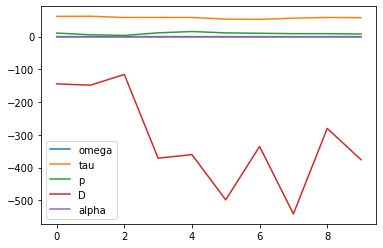

In [51]:
plt.plot(gradsnorm,label=["omega","tau","p","D","alpha"])
plt.legend()

In [3]:
theta = torch.tensor(np.array([500,0.5,0.1,0.01,1]),requires_grad=True)
m1 = m2 = 10
x1 = x2 = 0.4
h = 0.03
l0 = np.pi
wav1 = getsounds_imp_linear_nonorm(m1,m2,x1,x2,h,theta[None,:],l0)
wav2 = getsounds_imp_linear_nonorm(m1,m2,x1,x2,h,theta[None,:]+0.04,l0)

In [4]:
sr = 22050
display(ipd.Audio(wav1.squeeze().detach().numpy(),rate=sr))
display(ipd.Audio(wav2.squeeze().detach().numpy(),rate=sr))

In [18]:
y = ftm.getsounds_imp_linear_nonorm(m1,m2,x1,x2,h,0.5,500,0.1,0.01,np.pi,1,sr)
display(ipd.Audio(y,rate=sr))
###  yay torch implementation should be correct
print(np.linalg.norm(wav1.detach().numpy()-y/max(y)))

0.00032766470282012303


In [19]:
jtfs = TimeFrequencyScattering1D(
                J = 14, #scale
                shape = (2**16, ), 
                Q = 1, #filters per octave, frequency resolution
                T = 2**16, 
                F = 2,
                max_pad_factor=1,
                max_pad_factor_fr=1,
                average = True,
                average_fr = True,
            ).cuda()


In [22]:
jwav = jtfs(wav1).squeeze()

In [ ]:
id1 = jwav[0]
id1.backward()
theta.grad

In [6]:
djtfs = torch.norm(jtfs(wav1))

In [ ]:
djtfs.backward()

In [ ]:
theta.grad

In [12]:
print(theta)
print(wav1)
print(wav2)
print(theta.grad,wav1.grad)

tensor([5.0000e+02, 5.0000e-01, 1.0000e-01, 1.0000e-02, 1.0000e+00],
       dtype=torch.float64, requires_grad=True)
tensor([[[ 0.0000e+00,  9.6675e-02,  1.9154e-01,  ..., -1.3818e-04,
          -1.9353e-04, -2.4877e-04]]], dtype=torch.float64,
       grad_fn=<DivBackward0>)
tensor([[[ 0.0000,  0.0879,  0.1734,  ..., -0.0006, -0.0007, -0.0008]]],
       dtype=torch.float64, grad_fn=<DivBackward0>)
None None


In [ ]:
dwav_jtfs = torch.norm(jtfs(wav1)-jtfs(wav2))
dwav_jtfs.backward()

In [ ]:
wav,sr = sf.read("/home/han/data/drum_data/test/1005_sound.wav")
param = jtfs(wav)
